In [2]:
import sys
sys.path.append('..')
import pandas as pd
import matplotlib.pylab as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

In [32]:
corpus = [
    'This is a document.',
    'This document is the second document.',
    'And this is the third one document.',
    'Is this the first document?',
]

### CountVectorizer
Para comenzar a usar  [TfidfTransformer](https://kavita-ganesan.com/tfidftransformer-tfidfvectorizer-usage-differences/), primero tendrá que crear un CountVectorizer para contar el número de palabras (frecuencia de términos), limitar el tamaño de su vocabulario, aplicar palabras vacías , etc. El código siguiente hace precisamente eso.

Shape es (4, 9)


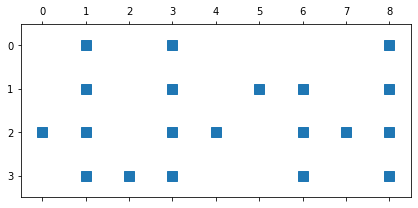

In [33]:
count_vectorizer = CountVectorizer()
word_count_vector = count_vectorizer.fit_transform(corpus)
plt.figure(figsize=(7,7))
plt.spy(word_count_vector)
print(f'Shape es {word_count_vector.shape}')

Ahora, revisemos la forma. Deberíamos tener 4 filas (4 documentos) y 9 columnas (9 palabras únicas, menos palabras de un solo carácter)

Ahora es el momento de calcular las IDF. Tenga en cuenta que en este ejemplo, estamos usando todos los valores predeterminados con CountVectorizer . De hecho, puede especificar una lista personalizada de palabras vacías, imponer un recuento mínimo de palabras, etc. Consulte este artículo sobre cómo utilizar [CountVectorizer](https://kavita-ganesan.com/how-to-use-countvectorizer/).

In [34]:
word_count_vector.toarray()

array([[0, 1, 0, 1, 0, 0, 0, 0, 1],
       [0, 2, 0, 1, 0, 1, 1, 0, 1],
       [1, 1, 0, 1, 1, 0, 1, 1, 1],
       [0, 1, 1, 1, 0, 0, 1, 0, 1]], dtype=int64)

### TfidfTransformer
Ahora vamos a calcular los valores [IDF](https://kavita-ganesan.com/what-is-inverse-document-frequency/) recurriendo ``` TfidfTran.fit(word_count_vector) ``` a los recuentos de palabras que calculamos anteriormente.

In [35]:
TfidfTran = TfidfTransformer()
TfidfTran.fit(word_count_vector)

TfidfTransformer()

In [36]:
df_idf = pd.DataFrame(TfidfTran.idf_, index=count_vectorizer.get_feature_names(),columns=["idf_weights"])
df_idf.sort_values('idf_weights')

,idf_weights
document,1.000000
is,1.000000
this,1.000000
the,1.223144
and,1.916291
first,1.916291
one,1.916291
second,1.916291
third,1.916291


Observe que las palabras 'document', 'is', 'the' y 'this' tienen los valores IDF más bajos. Esto es de esperar, ya que estas palabras aparecen en todos y cada uno de los documentos de nuestra colección. Cuanto menor sea el valor IDF de una palabra, menos exclusiva será para cualquier documento en particular.

**Nota importante:** En la práctica, su IDF debe basarse en un gran corpus de texto.

#### Calcule la puntuación TFIDF de sus documentos
Una vez que tenga los valores IDF, ahora puede calcular las puntuaciones tf-idf para cualquier documento o conjunto de documentos. Calculemos las puntuaciones tf-idf para los 5 documentos de nuestra colección.

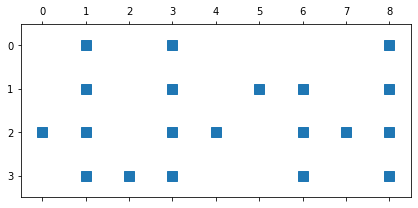

In [37]:
count_vector=count_vectorizer.transform(corpus)

tf_idf_vector = TfidfTran.transform(count_vector)

plt.figure(figsize=(7,7))
plt.spy(tf_idf_vector)

La primera línea de arriba, obtiene el recuento de palabras de los documentos en forma de matriz dispersa. De hecho, podríamos haber usado ``` word_count_vector ``` desde arriba. Sin embargo, en la práctica, es posible que esté calculando las puntuaciones tf-idf en un conjunto de documentos nuevos que no se han visto. Cuando haga eso, primero tendrá ``` cv.transform(your_new_docs) ``` que generar la matriz de recuentos de palabras.

Luego, al invocar ``` tfidf_transformer.transform(count_vector) ```, finalmente calculará las puntuaciones tf-idf para sus documentos. Internamente, esto está calculando la ``` tf * idf ```  multiplicación donde la frecuencia de su término está ponderada por sus valores IDF.

Ahora, imprimamos los valores tf-idf del primer documento para ver si tiene sentido. Lo que estamos haciendo a continuación es colocar las puntuaciones tf-idf del primer documento en un marco de datos de pandas y clasificarlo en orden descendente de puntuaciones.

In [38]:
tf_idf_vector.toarray().round(2)

array([[0.  , 0.58, 0.  , 0.58, 0.  , 0.  , 0.  , 0.  , 0.58],
       [0.  , 0.6 , 0.  , 0.3 , 0.  , 0.57, 0.37, 0.  , 0.3 ],
       [0.49, 0.25, 0.  , 0.25, 0.49, 0.  , 0.31, 0.49, 0.25],
       [0.  , 0.35, 0.67, 0.35, 0.  , 0.  , 0.43, 0.  , 0.35]])

In [40]:
feature_names = count_vectorizer.get_feature_names() 
 
#get tfidf vector for first document 
first_document_vector=tf_idf_vector[0] 
 
#print the scores 
df = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"]) 
df.sort_values(by=["tfidf"],ascending=False)

,tfidf
document,0.57735
is,0.57735
this,0.57735
and,0.00000
first,0.00000
one,0.00000
second,0.00000
the,0.00000
third,0.00000


Observe que solo ciertas palabras tienen puntajes. Esto se debe a que nuestro primer documento es “This is the first document.”   todas las palabras de este documento tienen una puntuación tf-idf y todo lo demás aparece como ceros. Observe que falta la palabra "a" en esta lista. Esto posiblemente se deba al preprocesamiento interno de CountVectorizer, donde elimina caracteres individuales.

Las puntuaciones anteriores tienen sentido. Cuanto más común sea la palabra en todos los documentos, menor será su puntuación y cuanto más única sea una palabra para nuestro primer documento (por ejemplo, "document", "is" y "this"), mayor será la puntuación. Entonces está funcionando como se esperaba, excepto por el misterioso a que fue cortado

### TfidfVectorizer
Ahora, vamos a utilizar los mismos 5 documentos de arriba para hacer lo mismo que hicimos con Tfidftransformer, que es obtener las puntuaciones tf-idf de un conjunto de documentos. Pero observe que esto es mucho más corto.

Con Tfidfvectorizer, calcula los recuentos de palabras, los valores idf y tf-idf todos a la vez. Es realmente simple.

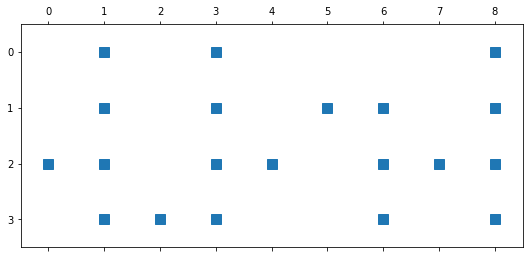

In [56]:
tfidf = TfidfVectorizer(min_df=1, max_df=1.0, ngram_range=(1, 1), use_idf=True)

tfidf_vectorizer_vectors = tfidf.fit_transform(corpus)

plt.figure(figsize=(9,9))
plt.spy(tfidf_vectorizer_vectors)

Ahora imprimamos los valores tfidf para el primer documento de nuestra colección. Note que estos valores son idénticos a los de Tfidftransformer, lo único es que se hace en solo dos pasos.

In [58]:
first_vector_tfidfvectorizer=tfidf_vectorizer_vectors[0] 

df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=tfidf.get_feature_names(), columns=["tfidf"]) 
df.sort_values(by=["tfidf"],ascending=False)

,tfidf
document,0.57735
is,0.57735
this,0.57735
and,0.00000
first,0.00000
one,0.00000
second,0.00000
the,0.00000
third,0.00000


### Tfidftransformer vs. Tfidfvectorizer
En resumen, la principal diferencia entre los dos módulos es la siguiente:

Con **Tfidftransformer** , calculará sistemáticamente los recuentos de palabras utilizando **CountVectorizer** y luego calculará los valores de **Frecuencia de documento inversa** (IDF) y solo entonces calculará las puntuaciones de Tf-idf.

Con **Tfidfvectorizer**, por el contrario, realizará los tres pasos a la vez. Bajo el capó, calcula los recuentos de palabras, los valores de IDF y las puntuaciones de Tf-idf, todos utilizando el mismo conjunto de datos.

### ¿Cuándo usar qué?
Así que ahora se estará preguntando por qué debería utilizar más pasos de los necesarios si puede hacer todo en dos pasos. Bueno, hay casos en los que desea utilizar Tfidftransformer sobre Tfidfvectorizer y, a veces, no es tan obvio. Aquí hay una pauta general:\
* Si necesita el término vectores de frecuencia (recuento de términos) para diferentes tareas, use Tfidftransformer.
* Si necesita calcular las puntuaciones tf-idf en documentos dentro de su conjunto de datos de "entrenamiento", use **Tfidfvectorizer**.
* Si necesita calcular las puntuaciones tf-idf en documentos fuera de su conjunto de datos de "entrenamiento", use cualquiera de ellos, **ambos funcionarán.**

### Recursos
* [Tutorial de Notebook para Tfidftransformer y Tfidfvectorizer](https://github.com/kavgan/nlp-in-practice/tree/master/tfidftransformer)

### Recommended Reading
* [Cómo utilizar CountVectorizer](https://kavita-ganesan.com/how-to-use-countvectorizer/)
* [Extracción de palabras clave con TF-IDF y Scikit Learn](https://kavita-ganesan.com/python-keyword-extraction/)
* [¿Qué es la frecuencia de término?](https://kavita-ganesan.com/what-is-term-frequency/#.Xb2W0pNKjm0)
* [¿Qué es IDF?](https://kavita-ganesan.com/what-is-inverse-document-frequency/)
